<a href="https://www.kaggle.com/code/johnleraas/subreddit-exploratorytextanalytics?scriptVersionId=91707616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# Pandas and NumPy
import pandas as pd
import numpy as np

# PCA
from sklearn.decomposition import PCA
from scipy.linalg import norm
from sklearn import decomposition
from sklearn.decomposition import PCA

# NLTK
import nltk
from nltk import word_tokenize
from nltk import regexp_tokenize
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Regular Expressions
import re

# Beautiful Soup
from bs4 import BeautifulSoup

#Word Embedding
from gensim.models import word2vec
from sklearn.manifold import TSNE

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.cluster.hierarchy as sch

# Similarity Measures
from scipy.spatial.distance import pdist


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/reddit-selfposts/rspct.tsv
/kaggle/input/reddit-selfposts/subreddit_info.csv


In [2]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 514 kB/s            


# User Defined Functions

### tfidf_func

Calculates TF-IDF based upon: Token Table, choice of bag, count method, term frequency method, and IDF method

In [4]:
def tfidf_func (TOKEN, bag, count_method, tf_method, idf_method):
      
    # Print Selections
    print('Choice of Bag:', bag)
    print('Count method:', count_method)
    print('TF method:', tf_method)
    print('IDF method:', idf_method)
    
    # BOW Model
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
        .to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    BOW.head(10)
    
    # Document-Term Count Matrix
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')
    DTCM.head()
    
    # Compute Term Frequency
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()

    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()

    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)

    elif tf_method == 'raw':
        TF = DTCM.T

    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming

    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')

    TF = TF.T
    
    # Compute Document Frequency
    DF = DTCM[DTCM > 0].count()
    DF.head()
    
    # Compute IDF
    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)

    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 

    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1
    
    # Compute TFIDF
    TFIDF = TF * IDF

    return TFIDF

### wordEmbedbyCategory
Based upon a specific category input: 
- creates corpus
- applies word2vec
- applies t-SNE
- plots 2D scatterplot of results

In [5]:
def wordEmbedbyCategory(cat):

    df_cat = df_embed[df_embed['category']==cat]


    corpus = df_cat.groupby(POST)\
        .term_str.apply(lambda  x:  x.tolist())\
        .reset_index()['term_str'].tolist()

    model = word2vec.Word2Vec(corpus, vector_size=246, window=5, min_count=200, workers=4)

    coords = pd.DataFrame(index=range(len(model.wv.key_to_index)))
    coords['label'] = [w for w in model.wv.key_to_index]
    coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))

    tsne_model = TSNE(perplexity=50, n_components=2, n_iter=2500, random_state=seednum)
    tsne_values = tsne_model.fit_transform(coords['vector'].tolist())

    coords['x'] = tsne_values[:,0]
    coords['y'] = tsne_values[:,1]

    fig = px.scatter(coords, 'x', 'y', text='label', height=1000, title = "Word Embedding t-SNE (Category: "+str(cat)+")").update_traces(mode='text')
    fig.update_layout(title_x = 0.5)
    fig.show()

### pc_vis

Given inputs matrix and two principal component numbers, creates 2D plot of principal components specified

In [7]:
def pc_vis(matrix, pc1, pc2, label='category', prefix='PC '):
    fig = px.scatter(matrix, prefix + str(pc1), prefix + str(pc2),
                    title = "PCA Analysis: " + prefix + str(pc1) +", "+prefix + str(pc2),
                    color = 'category')
    
    fig.update_layout(
        title={
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    
    fig.show()

### hca

Given similarity matrix, plots a dendogram

In [168]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10), title=""):
    tree = sch.linkage(sims, method=linkage_method)
    labels = list(list(DTM_SR.reset_index()['subreddit'].unique()))
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.title(title)
    
    plt.show()

# Other Setup

In [10]:
seednum = 314

OHCO = ['category', 'subreddit', 'post_id', 'para_num', 'sent_num', 'token_num']

CATEGORY = OHCO[:1]
SUBREDDIT = OHCO[:2]
POST = OHCO[:3]
PARA = OHCO[:4]
SENT = OHCO[:5]

# Exploratory Data Analysis

## Import Data

In [12]:
df = pd.read_csv("../input/reddit-selfposts/rspct.tsv", sep = '\t')

dfcat = pd.read_csv("../input/reddit-selfposts/subreddit_info.csv")

## Categorization Information

Information scraped directly from Reddit includes subreddit labeling. While users may potentially post in the wrong subreddit, there is no ambiguity regarding labeling. The researches painstakingly added three layers of categorization to each subreddit, explored below.

In [13]:
dfcat.head()

,subreddit,category_1,category_2,category_3,in_data,reason_for_exclusion
0,whatsthatbook,advice/question,book,NaN,True,NaN
1,CasualConversation,advice/question,broad,NaN,False,too_broad
2,Clairvoyantreadings,advice/question,broad,NaN,False,too_broad
3,DecidingToBeBetter,advice/question,broad,NaN,False,too_broad
4,HelpMeFind,advice/question,broad,NaN,False,too_broad


In [14]:
# Number of subreddits included by Category 1 values
dfcat[dfcat.in_data == True].category_1.value_counts()

video_game               100
tv_show                   68
health                    58
profession                56
software                  52
electronics               51
music                     43
sports                    40
sex/relationships         31
hobby                     30
geo                       29
crypto                    29
company/website           28
other                     27
anime/manga               26
drugs                     23
writing/stories           22
arts                      21
programming               21
autos                     20
advice/question           18
animals                   17
education                 17
social_group              16
politics/viewpoint        16
food/drink                15
card_game                 15
stem                      14
hardware/tools            14
parenting                 13
religion/supernatural     13
books                     12
appearance                11
finance/money             10
board_game    

In [15]:
# Number of unique categories
dfcat[dfcat.in_data == True].describe()

,subreddit,category_1,category_2,category_3,in_data,reason_for_exclusion
count,1013,1013,1013,136,1013,0
unique,1013,39,1013,105,1,0
top,whatsthatbook,video_game,book,country,True,NaN
freq,1,100,1,29,1013,NaN


In [16]:
# Number of subreddits included by Category 3 values
dfcat[dfcat.in_data == True].category_3.value_counts()

country        29
amazon          3
oculus rift     2
audible         1
tableau         1
               ..
roku            1
intel           1
synology        1
thinkpad        1
workflow        1
Name: category_3, Length: 105, dtype: int64

In [17]:
# Number of subreddits included by Category 3 values
dfcat[dfcat.in_data == True].category_3.isnull().count()

1013

__Note:__

Category 1 is used to group various subreddits and is useful for heirarchical categorization.

Category 2 is unique for each included subreddit, and so adds no additional value from a hierarchical perspective. 

Category 3 consists largely of null values, and so adds little value.

### Reddit Posts

In [18]:
df.head(5)

,id,subreddit,title,selftext
0,6d8knd,talesfromtechsupport,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,58mbft,teenmom,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,8f73s7,Harley,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,6ti6re,ringdoorbell,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,77sxto,intel,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


In [19]:
df.loc[2, 'selftext']

"Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys! "

In [20]:
df.loc[4, 'selftext']

'Prime95 (regardless of version) and OCCT both, the "small" tests (including those parts of blend) make my temps shoot up to 100c+/throttling even at pure stock with MCE off instantaneously (I find it mildly funny that this still passes in P95).    Any other stress test is lucky to spike up to 75 WITH an OC.   Real usage in say TW Warhammer 2 (what I believe is considered cpu heavy) is like low 60\'s.  I don\'t get it.<lb><lb>So, tell me this is normal/doesn\'t matter... please.   :-x<lb>'

__Note:__ the preceding text examples contain html tags, which should be cleaned prior to analysis.

In [21]:
# Number of Records
df.count()

id           1013000
subreddit    1013000
title        1013000
selftext     1013000
dtype: int64

In [22]:
# Number of Records by Subreddit
df.groupby('subreddit').count()

,id,title,selftext
subreddit,,,
13ReasonsWhy,1000,1000,1000
3Dprinting,1000,1000,1000
3d6,1000,1000,1000
4Runner,1000,1000,1000
7daystodie,1000,1000,1000
...,...,...,...
yandere_simulator,1000,1000,1000
ynab,1000,1000,1000
yoga,1000,1000,1000


In [23]:
# Missing Data
df.isnull().sum()

id           0
subreddit    0
title        0
selftext     0
dtype: int64

In [24]:
# Duplicates
df.nunique()

id           1013000
subreddit       1013
title        1002124
selftext     1013000
dtype: int64

In [25]:
df.describe()

,id,subreddit,title,selftext
count,1013000,1013000,1013000,1013000
unique,1013000,1013,1002124,1013000
top,6d8knd,talesfromtechsupport,Question,"Hi there, <lb>The usual. Long time lerker, fi..."
freq,1,1000,132,1


## Summary: Exploratory Data Analysis

- category_1 classification can be used as part of the document hierarchy
- 1,013 unique Subreddits
- No duplicate values
- No NaN or missing values
- 1,013,000 records
- 'title' and 'selftext' provide useful data
- 'subreddit' represents the data label
- OHCO levels may be include 'category_1' (subreddits grouped together by the researchers), 'subreddit' (grouping all text by subreddit), 'record' (individual reddit post), paragraph (using line breaks), sentence, and token
    - Some posts do not use formal/correct punctuation or consistent paragraph breaks, which may affect paragraph and sentence tokenization as well as POS (parts of speech) tagging
- The number of posts by classification are balanced at the subreddit level (though not at the category level)
- Original dataset is too large to process to final project specifications

# Data Processing

- No duplicate or missing values (each 'selftext' has unique value); no action needed

- Add 'category' information to token dataset

- Subsample Data
    - Chose 2 subreddits from each of the top 10 categories for analysis

- Add another column combining 'title' and 'selftext' using line breaks

- Clean text

    - Convert current line break tags to \n for tokenization
    - Address contractions (e.g. "won \ ' t") not addressed by BeautifulSoup
    - Utilize BeautifulSoup to clean tags

- Rename columns

## Add Category Information

In [27]:
df = pd.merge(df, dfcat[['subreddit', 'category_1']], how='left', on='subreddit')
df = df[['category_1', 'subreddit', 'id', 'title', 'selftext']]

In [28]:
df.head()

,category_1,subreddit,id,title,selftext
0,writing/stories,talesfromtechsupport,6d8knd,Remember your command line switches...,"Hi there, <lb>The usual. Long time lerker, fi..."
1,tv_show,teenmom,58mbft,"So what was Matt ""addicted"" to?",Did he ever say what his addiction was or is h...
2,autos,Harley,8f73s7,No Club Colors,Funny story. I went to college in Las Vegas. T...
3,hardware/tools,ringdoorbell,6ti6re,"Not door bell, but floodlight mount height.",I know this is a sub for the 'Ring Doorbell' b...
4,electronics,intel,77sxto,Worried about my 8700k small fft/data stress r...,"Prime95 (regardless of version) and OCCT both,..."


# Subsampling

Original dataset was too large to perform 'post-level' analysis on my personal machine. Chose to subsample two subreddits from each of the top 10 categories. Subreddits were chosen based upon my recognition (beetles, taylor swift) and/or interest (flyfishing).

In [29]:
# Full 20
subreddit_subset = ['btc', 'dogecoin', 'fitbit', 'gopro', 'france', 'Norway', 'camping', 'flyfishing', \
                    'TaylorSwift', 'beatles', 'Firefighting', 'ProtectAndServe', 'AdobeIllustrator', \
                    'salesforce', 'rugbyunion', 'soccer', 'DunderMifflin', 'TheSimpsons', 'CoDCompetitive', \
                    'FORTnITE']

In [30]:
# Subset choice of subreddits
df = df[df['subreddit'].isin(subreddit_subset)]

In [31]:
df['subreddit'].unique()

array(['FORTnITE', 'Firefighting', 'DunderMifflin', 'TheSimpsons',
       'soccer', 'camping', 'flyfishing', 'btc', 'AdobeIllustrator',
       'france', 'Norway', 'dogecoin', 'salesforce', 'rugbyunion',
       'CoDCompetitive', 'gopro', 'fitbit', 'ProtectAndServe',
       'TaylorSwift', 'beatles'], dtype=object)

## Preprocessing / Text Cleaning

### Combine Title and Text Body

In [32]:
# Combine Title & Body
df['text'] = df.title + " \n \n " + df.selftext

# Rename ID Column
df = df.rename(columns = {'id':'post_id'})

## Clean Text

- Convert current line break tags to \n for tokenization
- Address contractions (e.g. 'won\'t') not addressed by BeautifulSoup
- Utilize BeautifulSoup to clean tags

In [33]:
# Create 'clean' column
df['clean'] = df['text']

### Contractions/Parenthesis
First remove \ '

In [34]:
df['clean'] = df['clean'].str.replace("\'", "")

### Line Breaks

Convert HTML tags to "\n" for tokenization

In [35]:
df['clean'] = df['clean'].str.replace('<lb>', "\n")

### Convert HTML to Plain Text

Utilize BeautifulSoup

https://www.crummy.com/software/BeautifulSoup/bs4/doc/

In [36]:
df = df.reset_index()
df['clean'] = df['clean'].map(lambda text: BeautifulSoup(text, 'html.parser').get_text())

#### Rename Columns

Rename columns for more intuitive interpretation

In [37]:
df = df.rename(columns = {
    'category_1':'category',
    'title':'orig_title',
    'selftext':'orig_post',
    'text':'orig_text',
    'clean':'post'
})
df.head(2)

,index,category,subreddit,post_id,orig_title,orig_post,orig_text,post
0,37,video_game,FORTnITE,6pw9os,PSA: how to clear massive buildings quickly,Some/most people may be aware of this... buuut...,PSA: how to clear massive buildings quickly \n...,PSA: how to clear massive buildings quickly \n...
1,55,profession,Firefighting,5jolef,Help writing story about volunteer firefighters,"So, I'm a volunteer firefighter myself, and I ...",Help writing story about volunteer firefighter...,Help writing story about volunteer firefighter...


# Tokenization

Create TOKEN table, satisfying Machine Learning Corpus

- Split Paragraphs

- Paragraphs -> Sentences

- Sentences -> Tokens

- POS Tagging

In [38]:
OHCO = ['category', 'subreddit', 'post_id', 'para_num', 'sent_num', 'token_num']

CATEGORY = OHCO[:1]
SUBREDDIT = OHCO[:2]
POST = OHCO[:3]
SENTS = OHCO[:4]
PARA = OHCO[:5]
TOK = OHCO[:6]

In [39]:
# Create Token Table
TOKEN = df[['category', 'subreddit', 'post_id', 'post']]

# set Index
TOKEN.set_index(['category', 'subreddit', 'post_id'], append=True, inplace=True)
TOKEN = TOKEN.droplevel(None)
TOKEN.head(2)

,,,post
category,subreddit,post_id,
video_game,FORTnITE,6pw9os,PSA: how to clear massive buildings quickly \n...
profession,Firefighting,5jolef,Help writing story about volunteer firefighter...


## Split Paragraphs

In [40]:
TOKEN = TOKEN['post'].str.split(r'\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
TOKEN.index.names = OHCO[0:4] # Rename index columns
TOKEN['para_str'] = TOKEN['para_str'].str.replace(r'\n', ' ').str.strip() # Replace line breaks, strip white space
TOKEN = TOKEN[~TOKEN['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
TOKEN.head(3)

para_str
category   subreddit post_id para_num                                                   
video_game FORTnITE  6pw9os  0               PSA: how to clear massive buildings quickly
                             2         Some/most people may be aware of this... buuut...
                             3         If you have a large multistory building, clear...

## Split Paragraphs to Sentences

Utilize NLTK sentence tokenizer

https://www.nltk.org/api/nltk.tokenize.html

In [42]:
# Paragraphs to Sentences
TOKEN = TOKEN.para_str \
    .apply(lambda x: pd.Series(nltk.sent_tokenize(x))) \
    .stack() \
    .to_frame() \
    .rename(columns={0:'sent_str'})

TOKEN.index.names = OHCO[0:5] # Rename index columns

TOKEN.head(3)

sent_str
category   subreddit post_id para_num sent_num                                                   
video_game FORTnITE  6pw9os  0        0               PSA: how to clear massive buildings quickly
                             2        0         Some/most people may be aware of this... buuut...
                             3        0         If you have a large multistory building, clear...

## Split Sentences to Tokens

Utilize NLTK tokenizers

- Break into tokens
- Obtain parts of speech tags 

In [43]:
# Sentences to Tokens
# Function to pick tokenizer
def word_tokenize(x, ws=False):
    if ws:
        s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
    else:
        s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
    return s

In [44]:
%%time
TOKEN = TOKEN.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})

TOKEN.index.names = OHCO[0:6] # Rename index columns

TOKEN['token_str'] = TOKEN.pos_tuple.apply(lambda x: x[0]) # Get token_str from pos_tuple
TOKEN['pos'] = TOKEN.pos_tuple.apply(lambda x: x[1]) # Get POS from pos_tuple

CPU times: user 5min 28s, sys: 7.32 s, total: 5min 35s
Wall time: 5min 35s


In [45]:
TOKEN.sample(5)

pos_tuple  \
category   subreddit     post_id para_num sent_num token_num                 
tv_show    DunderMifflin 7qg8bn  5        0        2            (are, VBP)   
profession Firefighting  58e0dj  3        3        19         (heard, VBD)   
geo        france        7i4auy  0        0        2             (the, DT)   
                         69709j  4        3        4             (gap, NN)   
music      beatles       659z1z  4        0        25          (when, WRB)   

                                                             token_str  pos  
category   subreddit     post_id para_num sent_num token_num                 
tv_show    DunderMifflin 7qg8bn  5        0        2               are  VBP  
profession Firefighting  58e0dj  3        3        19            heard  VBD  
geo        france        7i4auy  0        0        2               the   DT  
                         69709j  4        3        4               gap   NN  
music      beatles       659z1z  4        0        25             when  WRB

__Note:__

__F1: Machine Learning Corpus Format__ - completed with preceding table

## Additional Cleaning
- Remove punctuation
- Convert to lowercase

In [47]:
# Convert to lower case and replace non-word characters
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')
TOKEN.sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


pos_tuple  \
category    subreddit        post_id para_num sent_num token_num                      
electronics fitbit           7g8d1m  6        0        6          (forgetting, VBG)   
sports      rugbyunion       5xfmv5  7        0        10                  (18, CD)   
software    AdobeIllustrator 4xr225  0        0        1                  (use, NN)   
electronics gopro            5ymm48  5        1        1             (possible, JJ)   
                             4ptdjv  4        2        2                 (card, NN)   
sports      rugbyunion       8e7dcj  2        1        18                  (to, TO)   
geo         Norway           5fjxfa  3        0        21                 (the, DT)   
tv_show     TheSimpsons      7hk5lx  5        0        11               (input, NN)   
music       beatles          6e5l8r  3        2        35                    (., .)   
crypto      btc              7jk49t  2        1        6                (them, PRP)   

                                                                   token_str  \
category    subreddit        post_id para_num sent_num token_num               
electronics fitbit           7g8d1m  6        0        6          forgetting   
sports      rugbyunion       5xfmv5  7        0        10                 18   
software    AdobeIllustrator 4xr225  0        0        1                 use   
electronics gopro            5ymm48  5        1        1            possible   
                             4ptdjv  4        2        2                card   
sports      rugbyunion       8e7dcj  2        1        18                 to   
geo         Norway           5fjxfa  3        0        21                the   
tv_show     TheSimpsons      7hk5lx  5        0        11              input   
music       beatles          6e5l8r  3        2        35                  .   
crypto      btc              7jk49t  2        1        6                them   

                                                                  pos  \
category    subreddit        post_id para_num sent_num token_num        
electronics fitbit           7g8d1m  6        0        6          VBG   
sports      rugbyunion       5xfmv5  7        0        10          CD   
software    AdobeIllustrator 4xr225  0        0        1           NN   
electronics gopro            5ymm48  5        1        1           JJ   
                             4ptdjv  4        2        2           NN   
sports      rugbyunion       8e7dcj  2        1        18          TO   
geo         Norway           5fjxfa  3        0        21          DT   
tv_show     TheSimpsons      7hk5lx  5        0        11          NN   
music       beatles          6e5l8r  3        2        35           .   
crypto      btc              7jk49t  2        1        6          PRP   

                                                                    term_str  
category    subreddit        post_id para_num sent_num token_num              
electronics fitbit           7g8d1m  6        0        6          forgetting  
sports      rugbyunion       5xfmv5  7        0        10                 18  
software    AdobeIllustrator 4xr225  0        0        1                 use  
electronics gopro            5ymm48  5        1        1            possible  
                             4ptdjv  4        2        2                card  
sports      rugbyunion       8e7dcj  2        1        18                 to  
geo         Norway           5fjxfa  3        0        21                the  
tv_show     TheSimpsons      7hk5lx  5        0        11              input  
music       beatles          6e5l8r  3        2        35                     
crypto      btc              7jk49t  2        1        6                them

# Create Key Tables

Key Files:

- Token - Includes OHCO structure for each token/term
- Vocabulary - Contains information related to each token/term
- Library - Contains metadata regarding documents
- Document - Contains information related to each document (PCA, topic modeling, etc.)

Conform to Machine Learning Corpus Format (F1) and Standard Text Analytical Data Models (F2)

## Create Library Table

In [48]:
LIB = df[['category', 'subreddit', 'post_id', 'orig_title', 'orig_text']]
LIB = LIB.set_index(['post_id'], append=True).droplevel(0)
LIB.head()

,category,subreddit,orig_title,orig_text
post_id,,,,
6pw9os,video_game,FORTnITE,PSA: how to clear massive buildings quickly,PSA: how to clear massive buildings quickly \n...
5jolef,profession,Firefighting,Help writing story about volunteer firefighters,Help writing story about volunteer firefighter...
7duumh,tv_show,DunderMifflin,Creed,Creed \n \n So what do we actually know about ...
4tt4vm,tv_show,TheSimpsons,"Are some episodes genuinely ""rarer"" than others?","Are some episodes genuinely ""rarer"" than other..."
72qy1e,sports,soccer,My idea for an European league,My idea for an European league \n \n This is j...


## Create Document Table

In [49]:
DOC = LIB[['category', 'subreddit', 'orig_title']].reset_index().set_index(POST)
DOC.head()

orig_title
category   subreddit     post_id                                                  
video_game FORTnITE      6pw9os        PSA: how to clear massive buildings quickly
profession Firefighting  5jolef    Help writing story about volunteer firefighters
tv_show    DunderMifflin 7duumh                                              Creed
           TheSimpsons   4tt4vm   Are some episodes genuinely "rarer" than others?
sports     soccer        72qy1e                     My idea for an European league

## Create Vocabulary Table

In [50]:
VOCAB = TOKEN.term_str.value_counts().to_frame() \
    .rename(columns={'index':'term_str', 'term_str':'n'}) \
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'

VOCAB.sample(8)

,term_str,n
term_id,,
75386,wwwfacebookcomgroupsgl3sh,1
33684,howard,9
17596,commercialbusiness,1
16590,citzen,1
6056,90200,1
75211,wwwcolumbiasoutherneduonlinedegreecontinuinged...,1
34139,ibrahimovicmanchester,1
71340,vally,1


### Match term_id between VOCAB and TOKEN tables

In [51]:
# Reset Index
VOCAB.reset_index()

# Add term_id to TOKEN df
VOCAB = VOCAB[~VOCAB.term_str.isna()]
TOKEN = TOKEN[~TOKEN.term_str.isna()]
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

In [52]:
TOKEN.head()

pos_tuple  \
category   subreddit post_id para_num sent_num token_num                
video_game FORTnITE  6pw9os  0        0        0            (PSA, NN)   
                                               1               (:, :)   
                                               2           (how, WRB)   
                                               3             (to, TO)   
                                               4          (clear, VB)   

                                                         token_str  pos  \
category   subreddit post_id para_num sent_num token_num                  
video_game FORTnITE  6pw9os  0        0        0               PSA   NN   
                                               1                 :    :   
                                               2               how  WRB   
                                               3                to   TO   
                                               4             clear   VB   

                                                         term_str  term_id  
category   subreddit post_id para_num sent_num token_num                    
video_game FORTnITE  6pw9os  0        0        0              psa    53131  
                                               1                         0  
                                               2              how    33683  
                                               3               to    67604  
                                               4            clear    16748

__Note:__

__F2: Standard Text Analytical Data Model__ - completed with: TOKEN table, DOC table, and VOCAB table.

# Annotate Tables

Annotate tables with statistical and linguistic features using NLP libraries such as NLTK (NLP Annotated Stadium - F3)

## VOCAB

- Identify Numbers
- Identify Stopwords
- Stemming
- Most Common Part of Speech (max_pos)

In [53]:
# Identify Numbers
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')
VOCAB.head(3)

,term_str,n,num
term_id,,,
0,,411694,0
1,0,589,1
2,00,76,1


In [54]:
# Stopwords
# Obtain Stop Words, set value to 1
stopwords = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str']) # Get Stopwords
stopwords = stopwords.reset_index().set_index('term_str')
stopwords['identify'] = 1 

# Apply to VOCAB table (stopword = 1, not stopword = 0)
VOCAB['stop'] = VOCAB.term_str.map(stopwords.identify)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

VOCAB[VOCAB['stop']==1].sample(3)

,term_str,n,num,stop
term_id,,,,
77127,yourself,155,0,1
32306,having,1521,0,1
48080,once,881,0,1


## Stemming

Add stems utilizing Porter Stemmer

https://www.nltk.org/api/nltk.stem.html

In [55]:
%%time
VOCAB['stem_porter'] = VOCAB.term_str.apply(PorterStemmer().stem)

CPU times: user 3.2 s, sys: 2.99 ms, total: 3.2 s
Wall time: 3.2 s


In [56]:
VOCAB.sample(3)

,term_str,n,num,stop,stem_porter
term_id,,,,,
58735,scholes25,1,0,0,scholes25
2247,20082012,1,1,0,20082012
50272,perch,9,0,0,perch


## Parts of Speech Max

Get most common part of speech use

In [57]:
posmax = TOKEN.groupby(['term_str', 'pos']).count() \
    .drop(columns=['token_str', 'term_id'])\
    .rename(columns={'pos_tuple':'count'})

posmax.sample(3)

,,count
term_str,pos,
donegan,NNP,1
minimap,NN,4
mpls,NNP,1


In [58]:
# Example
posmax.loc['fish']

,count
pos,
JJ,194
NN,333
NNP,17
NNS,1
VB,228
VBD,4
VBP,66
VBZ,1


In [59]:
# Get Index of Max Rows
mx = posmax.groupby(['term_str'])['count'].transform(max) == posmax['count']

# Keep only Max Rows
posmax = posmax[mx]

posmax.sample(5)

,,count
term_str,pos,
waking,VBG,26
hakizimana,NNP,1
yallop,NN,1
supervise,VB,1
downgraded,VBN,3


In [60]:
# Show Example Results
posmax.loc['fish']

,count
pos,
NN,333


In [61]:
# Add to VOCAB table

# Reset Index
posmax.reset_index(inplace = True)
# Join with VOCAB table
VOCAB = pd.merge(VOCAB, posmax, how = 'left', on='term_str')
# Rename columns
VOCAB.rename(columns={'count':'pos_max_count'}, inplace=True)
VOCAB.index.name = 'term_id'

VOCAB.sample(3)

,term_str,n,num,stop,stem_porter,pos,pos_max_count
term_id,,,,,,,
22859,disassociation,1,0,0,disassoci,NN,1
41112,lacicloud,6,0,0,lacicloud,NNP,5
1985,19941995,3,1,0,19941995,JJ,3


## Emotion & Sentiment

### NRC Lexicon

Add NRC Lexicon values to Token table

https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm

In [100]:
nrc_lex = pd.read_csv("../input/saif-mohammad-nrc-emotion-and-sentiment-lexicon/salex_nrc.csv")

In [101]:
nrc_lex.head()

,term_str,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
0,abandon,0,0,0,1,0,1,0,1,0,0
1,abandoned,1,0,0,1,0,1,0,1,0,0
2,abandonment,1,0,0,1,0,1,0,1,1,0
3,abduction,0,0,0,1,0,1,0,1,1,0
4,aberration,0,0,1,0,0,1,0,0,0,0


In [102]:
# Calculate Polarity
nrc_lex['polarity'] = nrc_lex['nrc_positive'] - nrc_lex['nrc_negative'] 

# Rename Columns
nrc_lex_cols = ['term_str',
                'anger',
                 'anticipation',
                 'disgust',
                 'fear',
                 'joy',
                 'negative',
                 'positive',               
                 'sadness',
                 'surprise',
                 'trust',
                 'polarity']

nrc_lex.columns = nrc_lex_cols

# Re-Order Columns in more intuitive way
nrc_lex_cols = ['term_str', 'anticipation', 'surprise',
 'anger', 'fear', 'disgust', 'sadness',
 'joy', 'trust',
 'negative', 'positive', 'polarity']

nrc_lex = nrc_lex[nrc_lex_cols]

# Set index to term_str
nrc_lex.set_index('term_str', inplace=True)

# Show
nrc_lex.head()

,anticipation,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,0,1,0,-1
abandoned,0,0,1,1,0,1,0,0,1,0,-1
abandonment,0,1,1,1,0,1,0,0,1,0,-1
abduction,0,1,0,1,0,1,0,0,1,0,-1
aberration,0,0,0,0,1,0,0,0,1,0,-1


### Merge Lexicon Values with Token Table

- Fill words with no lexicon value with '0' value

In [103]:
# Merge with TOKEN table
TOKEN = TOKEN.join(nrc_lex, on='term_str', how='left')

# Fill words with no nrc_lex value to zero
TOKEN[nrc_lex_cols] = TOKEN[nrc_lex_cols].fillna(0)

TOKEN[TOKEN['polarity'] == 1].sample(4)

pos_tuple  \
category   subreddit       post_id para_num sent_num token_num                  
profession ProtectAndServe 4o4ihk  2        1        8          (honest, JJS)   
                           75cnqq  2        1        26          (police, NN)   
software   salesforce      7pgnyn  2        1        9             (good, JJ)   
crypto     btc             7em60w  3        0        14            (good, JJ)   

                                                               token_str  pos  \
category   subreddit       post_id para_num sent_num token_num                  
profession ProtectAndServe 4o4ihk  2        1        8            honest  JJS   
                           75cnqq  2        1        26           police   NN   
software   salesforce      7pgnyn  2        1        9              good   JJ   
crypto     btc             7em60w  3        0        14             good   JJ   

                                                               term_str  \
category   subreddit       post_id para_num sent_num token_num            
profession ProtectAndServe 4o4ihk  2        1        8           honest   
                           75cnqq  2        1        26          police   
software   salesforce      7pgnyn  2        1        9             good   
crypto     btc             7em60w  3        0        14            good   

                                                                term_id  \
category   subreddit       post_id para_num sent_num token_num            
profession ProtectAndServe 4o4ihk  2        1        8            33420   
                           75cnqq  2        1        26           51512   
software   salesforce      7pgnyn  2        1        9            30574   
crypto     btc             7em60w  3        0        14           30574   

                                                                anticipation  \
category   subreddit       post_id para_num sent_num token_num                 
profession ProtectAndServe 4o4ihk  2        1        8                   0.0   
                           75cnqq  2        1        26                  0.0   
software   salesforce      7pgnyn  2        1        9                   1.0   
crypto     btc             7em60w  3        0        14                  1.0   

                                                                surprise  \
category   subreddit       post_id para_num sent_num token_num             
profession ProtectAndServe 4o4ihk  2        1        8               0.0   
                           75cnqq  2        1        26              0.0   
software   salesforce      7pgnyn  2        1        9               1.0   
crypto     btc             7em60w  3        0        14              1.0   

                                                                anger  fear  \
category   subreddit       post_id para_num sent_num token_num                
profession ProtectAndServe 4o4ihk  2        1        8            1.0   1.0   
                           75cnqq  2        1        26           0.0   1.0   
software   salesforce      7pgnyn  2        1        9            0.0   0.0   
crypto     btc             7em60w  3        0        14           0.0   0.0   

                                                                disgust  \
category   subreddit       post_id para_num sent_num token_num            
profession ProtectAndServe 4o4ihk  2        1        8              1.0   
                           75cnqq  2        1        26             0.0   
software   salesforce      7pgnyn  2        1        9              0.0   
crypto     btc             7em60w  3        0        14             0.0   

                                                                sadness  joy  \
category   subreddit       post_id para_num sent_num token_num                 
profession ProtectAndServe 4o4ihk  2        1        8              1.0  1.0   
                           75cnqq  2        1        26             0.0  0.0   
software

In [104]:
# Merge with VOCAB table
VOCAB = VOCAB.join(nrc_lex, on='term_str', how='left')

# Fill words with no nrc_lex value to zero
VOCAB[nrc_lex_cols] = VOCAB[nrc_lex_cols].fillna(0)

VOCAB[VOCAB['polarity'] == 1].sample(4)

,term_str,n,num,stop,stem_porter,pos,pos_max_count,anticipation,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity
term_id,,,,,,,,,,,,,,,,,,
30189,friendly,169,0,0,friendli,JJ,119,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
68826,symphony,1,0,0,symphoni,NN,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
68413,surety,1,0,0,sureti,NN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
75774,virtue,2,0,0,virtu,NN,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


__Note:__

__F3: Anntaed STADM__ - completed

## Vector Representation (TF-IDF)

Note: Dataset too larget to efficiently evaluate at OHCO "post-level". Primary bag size chosen to be "subreddit," however "category" also calculated

### Setup

In [105]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth

### Calculate TF-IDF at Category and Subreddit OHCO Levels

In [106]:
%%time
DTM_CAT = tfidf_func (TOKEN, CATEGORY, count_method, tf_method, idf_method)

Choice of Bag: ['category']
Count method: n
TF method: sum
IDF method: standard
CPU times: user 23.3 s, sys: 75.3 ms, total: 23.4 s
Wall time: 23.4 s


In [107]:
%%time
# Bag = Subreddit
DTM_SR = tfidf_func (TOKEN, SUBREDDIT, count_method, tf_method, idf_method)

Choice of Bag: ['category', 'subreddit']
Count method: n
TF method: sum
IDF method: standard
CPU times: user 16.6 s, sys: 3.55 ms, total: 16.6 s
Wall time: 16.6 s


### Add TF-IDF Values to Vocab Table

In [108]:
VOCAB['tfidf_category'] = DTM_CAT.sum()
VOCAB['tfidf_subreddit'] = DTM_SR.sum()

In [109]:
VOCAB.head()

,term_str,n,num,stop,stem_porter,pos,pos_max_count,anticipation,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity,tfidf_category,tfidf_subreddit
term_id,,,,,,,,,,,,,,,,,,,,
0,,411694,0,0,,.,156845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0,589,1,0,0,CD,549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,00,76,1,0,00,CD,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000039,0.000129
3,000,50,1,0,000,CD,50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016,0.000061
4,0000,7,1,0,0000,CD,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000016,0.000037


__Note:__

__F4: STADM with Vector Space Models__ - completed

# PCA

Note: obtaining the 'post-level' document-term matrix was too compute intensive for the original dataset, thus we will look at the "subreddit-level"

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

In [110]:
# Ensure Data is normalized
## Normalize length, but not variance (would exaggerate importance of rare words)
DTM_SR = DTM_SR.apply(lambda x: x/norm(x,2), 1)
DTM_SR = DTM_SR - DTM_SR.mean()

In [111]:
num_pcs = 20
pca = decomposition.PCA(n_components = num_pcs)
pca.fit(DTM_SR)

# Document Content Matrix - Document Term Matrix projected into PC space
DCM = pd.DataFrame(pca.transform(DTM_SR), columns=["PC {}".format(i) for i in range(0,num_pcs)])

# Add category/subreddit
DCM['category'] = DTM_SR.reset_index()['category']
DCM['subreddit'] = DTM_SR.reset_index()['subreddit']

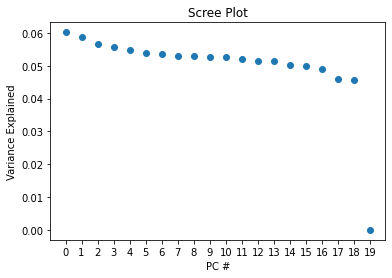

In [112]:
# Variance Explained for each component
var_exp = pca.explained_variance_ratio_

#Set Size
plt.rcParams["figure.figsize"] = (6,4)

# Scree Plot
plt.scatter(range(0,num_pcs), var_exp)
plt.xlabel('PC #')
plt.xticks(range(0, num_pcs))
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [113]:
categories = DCM['category'].to_list

In [114]:
pc_vis(DCM, 0, 1)

In [115]:
pc_vis(DCM, 2, 3)

In [116]:
pc_vis(DCM, 4, 5)

In [117]:
pc_vis(DCM, 6, 7)

## Get Loadings

In [118]:
# Get Loadings
pca.components_.T*np.sqrt(pca.explained_variance_)
LOADINGS = pd.DataFrame(pca.components_.T*np.sqrt(pca.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]

# Assign Index (termID from Document Term Matrix)
LOADINGS.index = DTM_SR.columns

# Add Term as separate column from VOCAB Table - for reference
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [119]:
# Show head with first two principal components
LOADINGS[['term_str','PC0', 'PC1']].head()

,term_str,PC0,PC1
term_id,,,
0,,-2.582609e-15,-1.059119e-15
1,0,1.741836e-15,-2.404836e-15
2,00,-6.367528e-04,-1.434490e-03
3,000,1.768195e-04,2.547271e-04
4,0000,3.353166e-04,1.008321e-04


## Save Loadings to Vocab Table

In [120]:
# Drop term_str column
LOADINGS = LOADINGS.drop(columns='term_str')

# Join Datasets
VOCAB = VOCAB.join(LOADINGS, on='term_id', how='left')

# Fill na's with 0
colnames = ["PC"+str(i) for i in range(0, num_pcs)]
VOCAB[colnames] = VOCAB[colnames].fillna(0)

In [121]:
VOCAB.head()

,term_str,n,num,stop,stem_porter,pos,pos_max_count,anticipation,surprise,anger,...,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
term_id,,,,,,,,,,,,,,,,,,,,,
0,,411694,0,0,,.,156845,0.0,0.0,0.0,...,4.868365e-16,-7.018675e-16,2.647180e-15,1.974344e-15,-6.125159e-16,5.839623e-16,-5.816853e-15,-1.124611e-16,-1.990819e-15,4.015353e-15
1,0,589,1,0,0,CD,549,0.0,0.0,0.0,...,1.486574e-16,1.921044e-17,-1.296894e-16,2.710646e-16,-2.365945e-15,-9.832806e-16,1.122569e-16,-8.239824e-17,-3.240220e-15,-1.473292e-15
2,00,76,1,0,00,CD,30,0.0,0.0,0.0,...,-1.772875e-04,1.778796e-04,-1.024510e-03,-1.342781e-03,-3.563337e-04,7.212566e-04,-3.763979e-03,-9.557186e-06,-1.352596e-04,-6.308190e-16
3,000,50,1,0,000,CD,50,0.0,0.0,0.0,...,7.150284e-05,-1.679774e-05,5.283639e-06,4.296880e-05,-3.574788e-05,-2.528966e-06,1.225830e-04,8.548223e-06,1.431540e-04,5.428331e-17
4,0000,7,1,0,0000,CD,6,0.0,0.0,0.0,...,-2.779810e-06,-1.045120e-05,-7.266713e-06,-1.058227e-05,8.142374e-05,-1.477106e-04,-2.732853e-05,-9.633004e-06,1.566614e-06,-6.832186e-16


# Topic Modeling

### Aggregate Nouns in Text by Post

In [122]:
POST_AGG = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(POST).term_str\
    .apply(lambda x: x.str.cat(sep=' '))\
    .to_frame()\
    .rename(columns={'term_str':'post_str'})

POST_AGG.head(2)

post_str
category subreddit post_id                                                   
crypto   btc       4m4zbr   spreadsheets spreadsheet day track investments...
                   4mc60u   anything asset community position vs debate di...

### Apply CountVectorizer to Posts and get Term Table

In [124]:
tfv = CountVectorizer(max_features=50000, stop_words='english')
tf = tfv.fit_transform(POST_AGG.post_str)
TERMS = tfv.get_feature_names_out()

### Use SciKitLearn LDA Fit Transformation to Obtain Theta

In [125]:
# Number of Topics
num_topics = 5

lda = LDA(n_components=num_topics, max_iter=10, learning_offset=50., random_state=0)
THETA = pd.DataFrame(lda.fit_transform(tf), index=POST_AGG.index)
THETA.columns.name = 'topic_id'

# Show Results
THETA.sample(5)

topic_id                                  0         1         2         3  \
category   subreddit      post_id                                           
hobby      flyfishing     5zugq9   0.006114  0.006015  0.005935  0.976027   
           camping        5w5qq9   0.926647  0.018203  0.018366  0.018478   
tv_show    DunderMifflin  6ohjfz   0.010123  0.010189  0.010054  0.503165   
music      TaylorSwift    6wke32   0.438602  0.533314  0.009229  0.009399   
video_game CoDCompetitive 7ypilt   0.054367  0.252656  0.008805  0.133198   

topic_id                                  4  
category   subreddit      post_id            
hobby      flyfishing     5zugq9   0.005910  
           camping        5w5qq9   0.018307  
tv_show    DunderMifflin  6ohjfz   0.466470  
music      TaylorSwift    6wke32   0.009456  
video_game CoDCompetitive 7ypilt   0.550973

#### Show Topic Weights of Each Subreddit

In [126]:
topic_cols = [t for t in range(num_topics)]
THETA.groupby('subreddit')[topic_cols].mean().T

subreddit,AdobeIllustrator,CoDCompetitive,DunderMifflin,FORTnITE,Firefighting,Norway,ProtectAndServe,TaylorSwift,TheSimpsons,beatles,btc,camping,dogecoin,fitbit,flyfishing,france,gopro,rugbyunion,salesforce,soccer
topic_id,,,,,,,,,,,,,,,,,,,,
0,0.076424,0.074161,0.071516,0.119286,0.162000,0.608366,0.162165,0.091298,0.067729,0.056104,0.731047,0.746727,0.781557,0.089803,0.159039,0.434310,0.152797,0.095910,0.415794,0.049146
1,0.022356,0.375168,0.082543,0.036034,0.033090,0.039415,0.037310,0.485271,0.087514,0.524056,0.048592,0.029638,0.040709,0.029945,0.022250,0.058995,0.053776,0.504251,0.035213,0.729103
2,0.038266,0.424319,0.097180,0.716328,0.419930,0.176136,0.476042,0.064735,0.084483,0.057127,0.089549,0.038771,0.059831,0.038884,0.056594,0.195038,0.053872,0.263154,0.293826,0.120816
3,0.050807,0.070781,0.651023,0.066379,0.156910,0.103017,0.201224,0.155737,0.610444,0.129657,0.056029,0.141551,0.040747,0.786356,0.727681,0.117301,0.541231,0.074337,0.054968,0.043352
4,0.812146,0.055571,0.097738,0.061974,0.228069,0.073066,0.123259,0.202960,0.149829,0.233055,0.074782,0.043312,0.077156,0.055012,0.034435,0.194355,0.198323,0.062348,0.200199,0.057583


### Use SciKitLearn LDA Fit Transformation to Obtain Phi

In [127]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'

#### Show Words Associated with each Topic

In [128]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

TOPICS

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



term_str,0,1,2,3,4,5,6,7,8,9
topic_id,,,,,,,,,,
0,time,thanks,wallet,trip,people,days,way,help,car,https
1,https,team,song,teams,songs,album,time,players,season,games
2,game,people,time,job,players,way,team,question,lot,year
3,time,episode,day,thanks,season,charge,fishing,water,way,camera
4,http,https,way,thanks,help,image,people,time,file,question


## Topic Model Visualizations

### Topics by Category

In [129]:
topCat = THETA.reset_index().groupby('category').mean().sort_values(0, ascending=False)
topCat

topic_id,0,1,2,3,4
category,,,,,
crypto,0.756302,0.044650,0.074690,0.048388,0.075969
geo,0.521338,0.049205,0.185587,0.110159,0.133711
hobby,0.452883,0.025944,0.047683,0.434616,0.038874
software,0.246109,0.028785,0.166046,0.052888,0.506172
profession,0.162083,0.035200,0.447986,0.179067,0.175664
electronics,0.121300,0.041861,0.046378,0.663794,0.126668
video_game,0.096723,0.205601,0.570323,0.068580,0.058772
music,0.073701,0.504664,0.060931,0.142697,0.218007
sports,0.072516,0.616733,0.191949,0.058837,0.059964


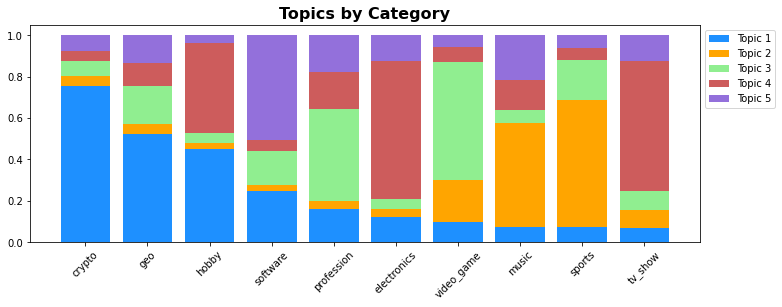

In [130]:
#Set Size
plt.rcParams["figure.figsize"] = (12,4)

x = topCat.index
y1 = topCat.loc[:, 0]
y2 = topCat.loc[:, 1]
y3 = topCat.loc[:, 2]
y4 = topCat.loc[:, 3]
y5 = topCat.loc[:, 4]

plt.bar(x, y1, color='dodgerblue')
plt.bar(x, y2, bottom = y1, color='orange')
plt.bar(x, y3, bottom = y1+y2, color='lightgreen')
plt.bar(x, y4, bottom = y1+y2+y3, color='indianred')
plt.bar(x, y5, bottom = y1+y2+y3+y4, color='mediumpurple')

plt.legend(["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"], bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.title("Topics by Category", fontweight='bold', fontsize=16)

plt.xticks(rotation = 45)
plt.show()

### Topics by Subreddit

In [131]:
topSR = THETA.reset_index().groupby('subreddit').mean().sort_values(0, ascending=False)
topSR

topic_id,0,1,2,3,4
subreddit,,,,,
dogecoin,0.781557,0.040709,0.059831,0.040747,0.077156
camping,0.746727,0.029638,0.038771,0.141551,0.043312
btc,0.731047,0.048592,0.089549,0.056029,0.074782
Norway,0.608366,0.039415,0.176136,0.103017,0.073066
france,0.434310,0.058995,0.195038,0.117301,0.194355
salesforce,0.415794,0.035213,0.293826,0.054968,0.200199
ProtectAndServe,0.162165,0.037310,0.476042,0.201224,0.123259
Firefighting,0.162000,0.033090,0.419930,0.156910,0.228069
flyfishing,0.159039,0.022250,0.056594,0.727681,0.034435


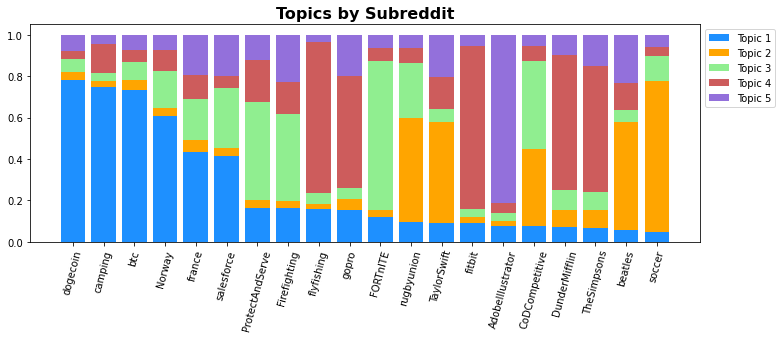

In [132]:
#Set Size
plt.rcParams["figure.figsize"] = (12,4)

x = topSR.index
y1 = topSR.loc[:, 0]
y2 = topSR.loc[:, 1]
y3 = topSR.loc[:, 2]
y4 = topSR.loc[:, 3]
y5 = topSR.loc[:, 4]

plt.bar(x, y1, color='dodgerblue')
plt.bar(x, y2, bottom = y1, color='orange')
plt.bar(x, y3, bottom = y1+y2, color='lightgreen')
plt.bar(x, y4, bottom = y1+y2+y3, color='indianred')
plt.bar(x, y5, bottom = y1+y2+y3+y4, color='mediumpurple')

plt.legend(["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5"], bbox_to_anchor=(1,1), loc='upper left', ncol = 1)
plt.title("Topics by Subreddit", fontweight='bold', fontsize=16)

plt.xticks(rotation = 75)
plt.show()

## Add Topics to Document Table

In [133]:
# Assign Results Table
topic_results = THETA

# Rename Columns
colnames = ["Topic "+str(i+1) for i in range(0, num_topics)]
topic_results.columns = colnames

# Join the tables
DOC = DOC.join(topic_results, on=POST, how='left')

DOC.head(3)

,,,orig_title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
category,subreddit,post_id,,,,,,
video_game,FORTnITE,6pw9os,PSA: how to clear massive buildings quickly,0.317725,0.011202,0.648621,0.011237,0.011216
profession,Firefighting,5jolef,Help writing story about volunteer firefighters,0.153009,0.002438,0.002489,0.028885,0.813180
tv_show,DunderMifflin,7duumh,Creed,0.018617,0.018786,0.281620,0.662178,0.018800


## Add Topics to Vocab Table

In [134]:
# Add PHI transposed
df_add = PHI.T

# Name Columns
cols = ["Topic "+str(i) for i in range(0, num_topics)]
df_add.columns = cols

# Merge with VOCAB table
VOCAB = VOCAB.join(df_add, on='term_str', how='left')

# Fill words with no Topic Values with zero
VOCAB[cols] = VOCAB[cols].fillna(0)

VOCAB.head(3)

,term_str,n,num,stop,stem_porter,pos,pos_max_count,anticipation,surprise,anger,...,PC15,PC16,PC17,PC18,PC19,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
term_id,,,,,,,,,,,,,,,,,,,,,
0,,411694,0,0,,.,156845,0.0,0.0,0.0,...,5.839623e-16,-5.816853e-15,-1.124611e-16,-1.990819e-15,4.015353e-15,0.00000,0.000000,0.000000,0.000000,0.000000
1,0,589,1,0,0,CD,549,0.0,0.0,0.0,...,-9.832806e-16,1.122569e-16,-8.239824e-17,-3.240220e-15,-1.473292e-15,0.00000,0.000000,0.000000,0.000000,0.000000
2,00,76,1,0,00,CD,30,0.0,0.0,0.0,...,7.212566e-04,-3.763979e-03,-9.557186e-06,-1.352596e-04,-6.308190e-16,0.20016,12.197959,0.200106,0.200001,0.201774


# Sentiment & Emotion

Use (1) NCR Sentiment Lexicon, which has already been added to Token Table and (2) VADER sentiment analysis

## NRC Sentiment & Emotion

NRC Sentiment & Emotion already added to Token table 

In [135]:
TOKEN[nrc_lex_cols].head(3)

term_str  \
category   subreddit post_id para_num sent_num token_num            
video_game FORTnITE  6pw9os  0        0        0              psa   
                                               1                    
                                               2              how   

                                                          anticipation  \
category   subreddit post_id para_num sent_num token_num                 
video_game FORTnITE  6pw9os  0        0        0                   0.0   
                                               1                   0.0   
                                               2                   0.0   

                                                          surprise  anger  \
category   subreddit post_id para_num sent_num token_num                    
video_game FORTnITE  6pw9os  0        0        0               0.0    0.0   
                                               1               0.0    0.0   
                                               2               0.0    0.0   

                                                          fear  disgust  \
category   subreddit post_id para_num sent_num token_num                  
video_game FORTnITE  6pw9os  0        0        0           0.0      0.0   
                                               1           0.0      0.0   
                                               2           0.0      0.0   

                                                          sadness  joy  trust  \
category   subreddit post_id para_num sent_num token_num                        
video_game FORTnITE  6pw9os  0        0        0              0.0  0.0    0.0   
                                               1              0.0  0.0    0.0   
                                               2              0.0  0.0    0.0   

                                                          negative  positive  \
category   subreddit post_id para_num sent_num token_num                       
video_game FORTnITE  6pw9os  0        0        0               0.0       0.0   
                                               1               0.0       0.0   
                                               2               0.0       0.0   

                                                          polarity  
category   subreddit post_id para_num sent_num token_num            
video_game FORTnITE  6pw9os  0        0        0               0.0  
                                               1               0.0  
                                               2               0.0

### Evaluate Emotion by Subreddit / Category

In [136]:
emo_results = TOKEN[nrc_lex_cols].groupby(SUBREDDIT).mean()

# Sort by Joy
emo_results.sort_values('joy', ascending=False, inplace=True)
emo_results

anticipation  surprise     anger      fear  \
category    subreddit                                                      
music       beatles               0.013766  0.007429  0.008393  0.008292   
            TaylorSwift           0.012250  0.006926  0.009774  0.009925   
video_game  FORTnITE              0.014754  0.008641  0.014427  0.011661   
tv_show     DunderMifflin         0.013297  0.007251  0.009750  0.010740   
            TheSimpsons           0.013412  0.008436  0.010063  0.012642   
geo         france                0.012551  0.006489  0.006193  0.008269   
electronics gopro                 0.013965  0.010299  0.008029  0.008962   
geo         Norway                0.012957  0.006239  0.004902  0.007264   
crypto      btc                   0.015083  0.006232  0.013799  0.013282   
hobby       flyfishing            0.012421  0.007816  0.006101  0.012405   
            camping               0.012641  0.007066  0.006218  0.008615   
crypto      dogecoin              0.012397  0.006376  0.006369  0.006430   
profession  Firefighting          0.014842  0.006958  0.006370  0.011801   
software    AdobeIllustrator      0.008298  0.004455  0.003688  0.007500   
video_game  CoDCompetitive        0.012853  0.006822  0.009837  0.011130   
profession  ProtectAndServe       0.011873  0.006402  0.012658  0.019985   
sports      rugbyunion            0.012459  0.007085  0.009966  0.010806   
software    salesforce            0.010569  0.005261  0.004282  0.006973   
sports      soccer                0.012011  0.006457  0.008050  0.008340   
electronics fitbit                0.010035  0.005040  0.008392  0.009413   

                               disgust   sadness       joy     trust  \
category    subreddit                                                  
music       beatles           0.008753  0.011888  0.021440  0.018246   
            TaylorSwift       0.007552  0.012704  0.020119  0.016817   
video_game  FORTnITE          0.007310  0.012315  0.016851  0.020242   
tv_show     DunderMifflin     0.007901  0.010675  0.015998  0.016496   
            TheSimpsons       0.008285  0.011515  0.015230  0.015936   
geo         france            0.004492  0.008321  0.014745  0.017365   
electronics gopro             0.003460  0.011732  0.014721  0.016470   
geo         Norway            0.003406  0.007909  0.014687  0.016822   
crypto      btc               0.004896  0.009223  0.014455  0.020675   
hobby       flyfishing        0.005048  0.007944  0.014346  0.022486   
            camping           0.005261  0.008520  0.014234  0.017135   
crypto      dogecoin          0.003689  0.007835  0.013944  0.016420   
profession  Firefighting      0.004686  0.008831  0.013557  0.019268   
software    AdobeIllustrator  0.002851  0.009568  0.012086  0.011691   
video_game  CoDCompetitive    0.006192  0.010568  0.011988  0.016029   
profession  ProtectAndServe   0.006884  0.011728  0.011618  0.024311   
sports      rugbyunion        0.005044  0.009782  0.011512  0.014437   
software    salesforce        0.002182  0.006599  0.011010  0.015313   
sports      soccer            0.004172  0.008188  0.010643  0.013687   
electronics fitbit            0.004684  0.009302  0.009642  0.013306   

                              negative  positive  polarity  
category    subreddit                                       
music       beatles           0.017254  0.028128  0.010874  
            TaylorSwift       0.016336  0.027210  0.010874  
video_game  FORTnITE          0.020146  0.027448  0.007303  
tv_show     DunderMifflin     0.016807  0.021877  0.005070  
            TheSimpsons       0.018475  0.021761  0.003286  
geo         france            0.011783  0.024018  0.012236  
electronics gopro             0.017138  0.020268  0.003129  
geo         Norway            0.009937  0.024205  0.014268  
crypto      btc               0.016134  0.024235  0.008102  
hobby       flyfishing        0.011555  0.027279  0.015723  
            camping           0.012685  

#### Visualize 'Negative' Emotions

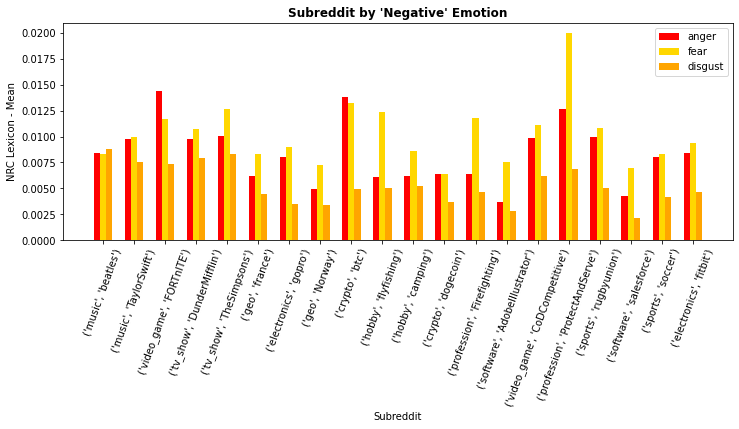

In [137]:
# x-labels
x_labels = emo_results.index

#y-bars
y1=emo_results.anger
y2=emo_results.fear
y3=emo_results.disgust

#x-axis
x_axis = np.arange(len(x_labels))

#bars in chart
col_width = 0.2
plt.bar(x_axis - col_width, y1, color = 'r', width = col_width, label = y1)
plt.bar(x_axis, y2, col_width, color = 'gold', label = y2)
plt.bar(x_axis + col_width, y3, col_width, color = 'orange', label = y3)

#x-labels
plt.xticks(x_axis, x_labels, rotation = 70)

plt.title("Subreddit by 'Negative' Emotion", fontweight = "bold")
plt.xlabel("Subreddit")
plt.ylabel("NRC Lexicon - Mean")
plt.legend(['anger', 'fear', 'disgust'])

plt.show()

#### Visualize 'Positive' Emotions

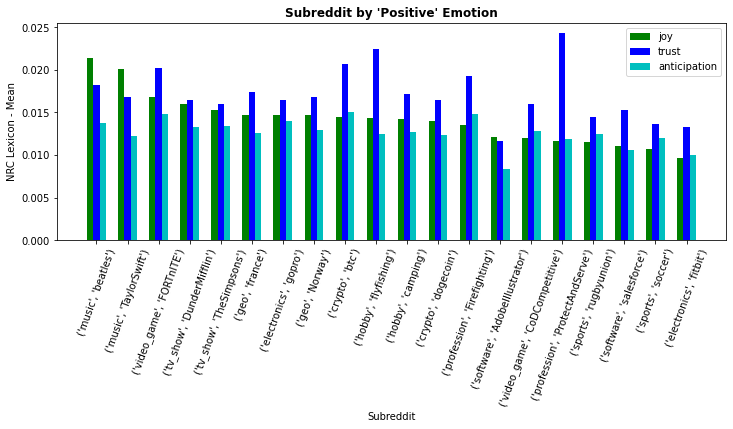

In [138]:
# x-labels
x_labels = emo_results.index

#y-bars
y1=emo_results.joy
y2=emo_results.trust
y3=emo_results.anticipation

#x-axis
x_axis = np.arange(len(x_labels))

#bars in chart
col_width = 0.2
plt.bar(x_axis - col_width, y1, color = 'g', width = col_width, label = y1)
plt.bar(x_axis, y2, col_width, color = 'b', label = y2)
plt.bar(x_axis + col_width, y3, col_width, color = 'c', label = y3)

#x-labels
plt.xticks(x_axis, x_labels, rotation = 70)

plt.title("Subreddit by 'Positive' Emotion", fontweight = "bold")
plt.xlabel("Subreddit")
plt.ylabel("NRC Lexicon - Mean")
plt.legend(['joy', 'trust', 'anticipation'])

plt.show()

### Save NRC Sentiment & Emotions to Document Table

In [139]:
emo_results = TOKEN[nrc_lex_cols].groupby(POST).mean()

# Sort by Joy
emo_results.sort_values('joy', ascending=False, inplace=True)
emo_results.head(3)

,,,anticipation,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity
category,subreddit,post_id,,,,,,,,,,,
sports,soccer,8ah62p,0.068182,0.034091,0.011364,0.000000,0.000000,0.056818,0.136364,0.034091,0.011364,0.136364,0.125000
profession,Firefighting,6ntmj3,0.093750,0.015625,0.000000,0.046875,0.000000,0.000000,0.125000,0.109375,0.015625,0.125000,0.109375
crypto,dogecoin,86ercu,0.084507,0.084507,0.028169,0.028169,0.028169,0.028169,0.112676,0.084507,0.028169,0.112676,0.084507


In [140]:
DOC = DOC.join(emo_results, on=POST, how='left')
DOC.head(3)

,,,orig_title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,anticipation,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity
category,subreddit,post_id,,,,,,,,,,,,,,,,,
video_game,FORTnITE,6pw9os,PSA: how to clear massive buildings quickly,0.317725,0.011202,0.648621,0.011237,0.011216,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.012346,0.000000,0.012346,0.012346
profession,Firefighting,5jolef,Help writing story about volunteer firefighters,0.153009,0.002438,0.002489,0.028885,0.813180,0.023136,0.010283,0.0,0.015424,0.005141,0.005141,0.020566,0.038560,0.002571,0.041131,0.038560
tv_show,DunderMifflin,7duumh,Creed,0.018617,0.018786,0.281620,0.662178,0.018800,0.017544,0.017544,0.0,0.017544,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.017544


## VADER Sentiment Analysis

VADER - Valence Aware Dictionary for sEntiment Reasoning

Evaluate at OHCO 'sentence' level

#### VADER Setup

In [141]:
# Vader sentiment analyser
analyser = SentimentIntensityAnalyzer()

# Group Token table by sentences and name appropriately
SENTIMENT = TOKEN.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' ')).to_frame()
SENTIMENT.rename(columns={'term_str':'sent_str'}, inplace=True)

# Apply Vader Sentiment Analyser
VADER_SENT = SENTIMENT.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
VADER_SENT.head()

neg    neu    pos  compound
category subreddit post_id para_num                             
crypto   btc       4m4zbr  0         0.0  1.000  0.000    0.0000
                           2         0.0  1.000  0.000    0.0000
                           3         0.0  0.835  0.165    0.9097
                   4mc60u  0         0.0  0.857  0.143    0.3612
                           2         0.0  0.886  0.114    0.6908

In [142]:
# Add Vader columns to sentiment table
SENTIMENT = pd.concat([SENTIMENT, VADER_SENT], axis=1)
SENTIMENT.head()

sent_str  \
category subreddit post_id para_num                                                      
crypto   btc       4m4zbr  0                       spreadsheets  show me what you got    
                           2         ive been working on revamping my spreadsheet a...   
                           3         honestly  i think my spreadsheet is dogshit an...   
                   4mc60u  0         has andreas yiannopoulos made it known officia...   
                           2         andreas is definitely an asset to the communit...   

                                     neg    neu    pos  compound  
category subreddit post_id para_num                               
crypto   btc       4m4zbr  0         0.0  1.000  0.000    0.0000  
                           2         0.0  1.000  0.000    0.0000  
                           3         0.0  0.835  0.165    0.9097  
                   4mc60u  0         0.0  0.857  0.143    0.3612  
                           2         0.0  0.886  0.114    0.6908

## Visualize Results by Category

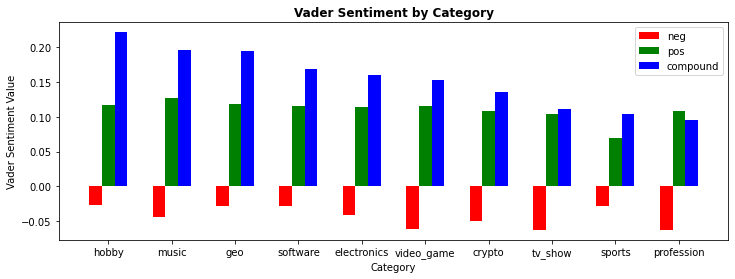

In [143]:
#x-labels
cat = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(CATEGORY).mean().sort_values('compound', ascending=False)['neg'].index

#y-bars
neg = -VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(CATEGORY).mean().sort_values('compound', ascending=False)['neg']
pos = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(CATEGORY).mean().sort_values('compound', ascending=False)['pos']
compound = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(CATEGORY).mean().sort_values('compound', ascending=False)['compound']

#x-axis
x_axis = np.arange(len(cat))

#bars in chart
col_width = 0.2
plt.bar(x_axis - col_width, neg, color = 'r', width = col_width, label = "neg")
plt.bar(x_axis, pos, col_width, color = 'g', label = "pos")
plt.bar(x_axis + col_width, compound, col_width, color = 'b', label ="compound")

#x-labels
plt.xticks(x_axis, cat)

plt.title("Vader Sentiment by Category", fontweight = "bold")
plt.xlabel("Category")
plt.ylabel("Vader Sentiment Value")
plt.legend()

plt.show()

## Visualize Results by Subreddit

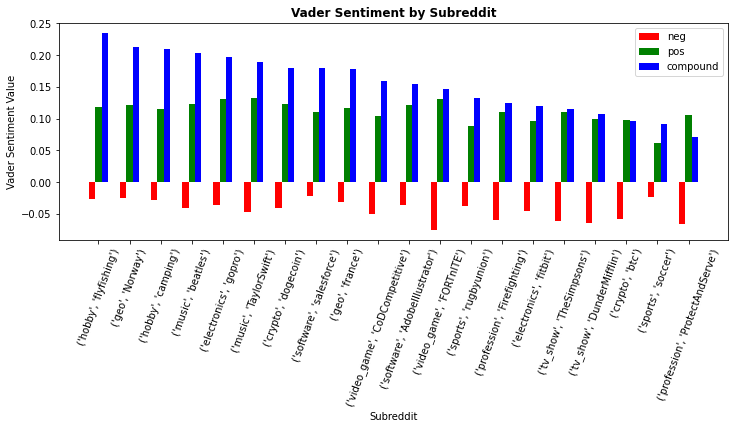

In [144]:
#x-labels
cat = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(SUBREDDIT).mean().sort_values('compound', ascending=False)['neg'].index

#y-bars
neg = -VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(SUBREDDIT).mean().sort_values('compound', ascending=False)['neg']
pos = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(SUBREDDIT).mean().sort_values('compound', ascending=False)['pos']
compound = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(SUBREDDIT).mean().sort_values('compound', ascending=False)['compound']

#x-axis
x_axis = np.arange(len(cat))

#bars in chart
col_width = 0.2
plt.bar(x_axis - col_width, neg, color = 'r', width = col_width, label = "neg")
plt.bar(x_axis, pos, col_width, color = 'g', label = "pos")
plt.bar(x_axis + col_width, compound, col_width, color = 'b', label ="compound")

#x-labels
plt.xticks(x_axis, cat, rotation = 70)

plt.title("Vader Sentiment by Subreddit", fontweight = "bold")
plt.xlabel("Subreddit")
plt.ylabel("Vader Sentiment Value")
plt.legend()

plt.show()

## Visualize Results by Post

Due to number of points and overlap across different categories, aggregate visualizations are more insightful

In [145]:
sentResults_POST = VADER_SENT[['neg', 'neu', 'pos', 'compound']].groupby(POST).mean().reset_index()

In [146]:
label='category'
fig = px.scatter(sentResults_POST, 'neg', 'pos',
                title = "VADER Sentiment Scatter Plot",
                color = 'category')

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

### Add Vader Sentiment Values to Document Matrix

In [147]:
# Set Index
sentResults_POST.set_index(POST, inplace=True)
sentResults_POST.head(3)

# Rename Columns
sentResults_POST.rename(columns={"neg":"vader_negative", 
                           "pos":"vader_positive", 
                           "neu":"vader_neutral", 
                           "compound":"vader_compound"}, 
                  inplace=True)

In [148]:
DOC = DOC.join(sentResults_POST, on=POST, how='left')
DOC.head(3)

,,,orig_title,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,anticipation,surprise,anger,fear,...,sadness,joy,trust,negative,positive,polarity,vader_negative,vader_neutral,vader_positive,vader_compound
category,subreddit,post_id,,,,,,,,,,,,,,,,,,,,,
video_game,FORTnITE,6pw9os,PSA: how to clear massive buildings quickly,0.317725,0.011202,0.648621,0.011237,0.011216,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.012346,0.000000,0.012346,0.012346,0.02325,0.80175,0.1750,0.33645
profession,Firefighting,5jolef,Help writing story about volunteer firefighters,0.153009,0.002438,0.002489,0.028885,0.813180,0.023136,0.010283,0.0,0.015424,...,0.005141,0.020566,0.038560,0.002571,0.041131,0.038560,0.06200,0.81480,0.1234,-0.00766
tv_show,DunderMifflin,7duumh,Creed,0.018617,0.018786,0.281620,0.662178,0.018800,0.017544,0.017544,0.0,0.017544,...,0.000000,0.000000,0.017544,0.000000,0.017544,0.017544,0.00000,0.96400,0.0360,0.29265


# Word Embeddings

Utilize scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

### Create Word Embedding Table from Token Table

- Remove proper nouns

In [149]:
# Remove null term_str
df_embed = TOKEN[~TOKEN.term_str.isnull()]

# Remove proper nouns
df_embed = df_embed[~df_embed.pos.str.match('NNPS?')]

# Remove punctuation, etc.
df_embed = df_embed[df_embed.term_id != 0]

# Reset index
df_embed = df_embed.reset_index()

df_embed.head(5)

,category,subreddit,post_id,para_num,sent_num,token_num,pos_tuple,token_str,pos,term_str,...,surprise,anger,fear,disgust,sadness,joy,trust,negative,positive,polarity
0,video_game,FORTnITE,6pw9os,0,0,0,"(PSA, NN)",PSA,NN,psa,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,video_game,FORTnITE,6pw9os,0,0,2,"(how, WRB)",how,WRB,how,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,video_game,FORTnITE,6pw9os,0,0,3,"(to, TO)",to,TO,to,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,video_game,FORTnITE,6pw9os,0,0,4,"(clear, VB)",clear,VB,clear,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,video_game,FORTnITE,6pw9os,0,0,5,"(massive, JJ)",massive,JJ,massive,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
# Create corpus of posts
corpus = df_embed.groupby(POST)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()

### Apply Word2Vec

In [151]:
model = word2vec.Word2Vec(corpus, vector_size=246, window=5, min_count=200, workers=4)

coords = pd.DataFrame(index=range(len(model.wv.key_to_index)))
coords['label'] = [w for w in model.wv.key_to_index]
coords['vector'] = coords['label'].apply(lambda x: model.wv.get_vector(x))

### Obtain t-SNE coordinates

In [152]:
tsne_model = TSNE(perplexity=50, n_components=2, n_iter=2500, random_state=seednum)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())

coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]

coords.head()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,label,vector,x,y
0,the,"[-0.069948494, -0.09278709, 0.14771305, 0.0348...",-0.903608,-11.504844
1,to,"[0.6094257, 0.050005127, -0.0049776295, 0.0981...",0.208074,-15.646996
2,i,"[-0.76781696, 0.5234707, 1.3877627, -0.3824445...",-4.090890,-16.533594
3,a,"[-0.4780695, -0.74390066, 0.24796784, 0.881563...",-4.171432,25.610794
4,and,"[0.20871975, 0.05686635, 0.43639898, 0.7255173...",-3.000872,22.217852


## Word Embedding Visualizations

### Word Embedding - Entire Corpus

Note: the proceeding visualization is fairly difficult to draw interesting observations from, however the proceeding category level model visualizations provide more detailed insight on particular categories.

In [153]:
px.scatter(coords, 'x', 'y', text='label', height=1000, title = 'All Posts').update_traces(mode='text')

### Word Embedding by Category

In [154]:
wordEmbedbyCategory('profession')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [155]:
wordEmbedbyCategory('hobby')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### Save Word Embeddings to Vocab Table

Save corpus level model

In [156]:
coords = coords.rename(columns={"label":"term_str", 
                                 "vector":"word_embedding",
                                 "x":"x_tsne",
                                 "y":"y_tsne"}) 

In [157]:
VOCAB = pd.merge(VOCAB.reset_index(), coords, how='left', on='term_str').set_index('term_id')
VOCAB[['word_embedding', 'x_tsne', 'y_tsne']] = VOCAB[['word_embedding', 'x_tsne', 'y_tsne']].fillna(0)
VOCAB.head(3)

,term_str,n,num,stop,stem_porter,pos,pos_max_count,anticipation,surprise,anger,...,PC18,PC19,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,word_embedding,x_tsne,y_tsne
term_id,,,,,,,,,,,,,,,,,,,,,
0,,411694,0,0,,.,156845,0.0,0.0,0.0,...,-1.990819e-15,4.015353e-15,0.00000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
1,0,589,1,0,0,CD,549,0.0,0.0,0.0,...,-3.240220e-15,-1.473292e-15,0.00000,0.000000,0.000000,0.000000,0.000000,"[-0.19096607, -0.10783457, -0.526655, -0.33511...",26.064619,13.487218
2,00,76,1,0,00,CD,30,0.0,0.0,0.0,...,-1.352596e-04,-6.308190e-16,0.20016,12.197959,0.200106,0.200001,0.201774,0,0.000000,0.000000


# Similarity Measures

Look simply at the following subreddit-level distance measures:
- Cosine Similarity
- Jensen Shannon Divergence


In [158]:
DTM_SR.head()

term_id                0      1         2         3         4         5      \
category    subreddit                                                         
crypto      btc          0.0    0.0 -0.001377  0.000891  0.001034  0.001211   
            dogecoin     0.0    0.0 -0.001377  0.000860  0.001097 -0.000064   
electronics fitbit       0.0    0.0 -0.001377 -0.000203 -0.000177 -0.000064   
            gopro        0.0    0.0 -0.000982  0.000093 -0.000177 -0.000064   
geo         Norway       0.0    0.0 -0.001377  0.000101 -0.000177 -0.000064   

term_id                   6         7         8         9      ...    77783  \
category    subreddit                                          ...            
crypto      btc       -0.000033 -0.000067 -0.000034 -0.000034  ... -0.00005   
            dogecoin  -0.000033  0.001273  0.000637  0.000637  ... -0.00005   
electronics fitbit     0.000626 -0.000067 -0.000034 -0.000034  ... -0.00005   
            gopro     -0.000033 -0.000067 -0.000034 -0.000034  ... -0.00005   
geo         Norway    -0.000033 -0.000067 -0.000034 -0.000034  ... -0.00005   

term_id                  77784    77785    77786    77787    77788    77789  \
category    subreddit                                                         
crypto      btc       -0.00005 -0.00005 -0.00005 -0.00005 -0.00005 -0.00005   
            dogecoin  -0.00005 -0.00005 -0.00005 -0.00005 -0.00005 -0.00005   
electronics fitbit    -0.00005 -0.00005 -0.00005 -0.00005 -0.00005 -0.00005   
            gopro     -0.00005 -0.00005 -0.00005 -0.00005 -0.00005 -0.00005   
geo         Norway    -0.00005 -0.00005 -0.00005 -0.00005 -0.00005 -0.00005   

term_id                  77790     77791     77792  
category    subreddit                               
crypto      btc       -0.00005 -0.000106 -0.000083  
            dogecoin  -0.00005 -0.000106 -0.000083  
electronics fitbit    -0.00005 -0.000106 -0.000083  
            gopro     -0.00005 -0.000106 -0.000083  
geo         Norway    -0.00005 -0.000106 -0.000083  

[5 rows x 77793 columns]

In [159]:
DTM_SR = tfidf_func(TOKEN, SUBREDDIT, count_method, tf_method, idf_method)
DTM_SR.head()

Choice of Bag: ['category', 'subreddit']
Count method: n
TF method: sum
IDF method: standard


In [161]:
# Apply L1 Normalization
L1 = DTM_SR.apply(lambda x: x / x.sum(), 1)

# Obtain subreddit Pairs
pairSR = DTM_SR.reset_index()['subreddit'].unique().tolist()
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([pairSR, pairSR])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['SR1', 'SR2']

In [162]:
# Calculate Distances:

# Cosine Similarity
PAIRS['cosine'] = pdist(DTM_SR, 'cosine')

# Jensen Shannon Divergence
PAIRS['jensenshannon'] = pdist(L1, 'jensenshannon')

PAIRS.head()

cosine  jensenshannon
SR1 SR2                              
btc dogecoin  0.868816       0.688823
    fitbit    0.999438       0.793882
    gopro     0.998922       0.794287
    france    0.997956       0.795656
    camping   0.997918       0.793806

## Visualize Distance

### Heatmap - Cosine Similarity

Text(0.5, 1.0, 'Cosine Similarity Heatmap - Subreddit')

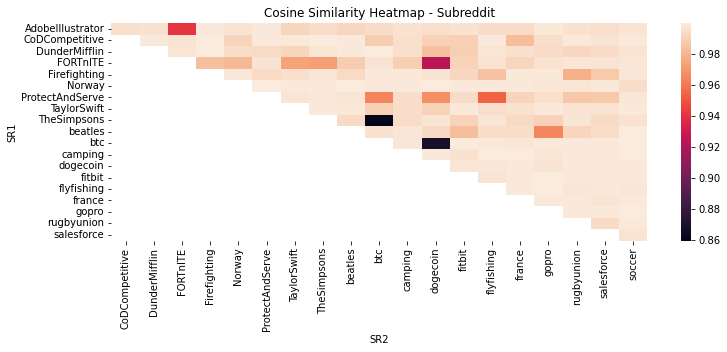

In [163]:
data = PAIRS.reset_index().pivot("SR1", "SR2", "cosine")
ax = sns.heatmap(data)
ax.set_title('Cosine Similarity Heatmap - Subreddit')

In [164]:
data

SR2,CoDCompetitive,DunderMifflin,FORTnITE,Firefighting,Norway,ProtectAndServe,TaylorSwift,TheSimpsons,beatles,btc,camping,dogecoin,fitbit,flyfishing,france,gopro,rugbyunion,salesforce,soccer
SR1,,,,,,,,,,,,,,,,,,,
AdobeIllustrator,0.995783,0.995905,0.941001,0.998770,0.996698,0.998938,0.991692,0.994673,0.992095,0.994118,0.995842,0.994723,0.996240,0.994021,0.993719,0.998197,0.996030,0.994872,0.996738
CoDCompetitive,NaN,0.998837,0.996769,0.999126,0.991257,0.998742,0.998466,0.999390,0.999012,0.988557,0.995550,0.990080,0.989383,0.998743,0.982899,0.995110,0.998620,0.996576,0.998516
DunderMifflin,NaN,NaN,0.996973,0.999359,0.994383,0.993515,0.991891,0.997425,0.998897,0.999132,0.995326,0.984136,0.989113,0.997242,0.995622,0.994048,0.992363,0.993758,0.996432
FORTnITE,NaN,NaN,NaN,0.983726,0.981148,0.996626,0.973644,0.971833,0.988278,0.996796,0.989197,0.923998,0.990858,0.996039,0.991692,0.996000,0.997653,0.996786,0.997833
Firefighting,NaN,NaN,NaN,NaN,0.998961,0.993208,0.995496,0.997719,0.993510,0.998867,0.998342,0.996848,0.992299,0.984529,0.998423,0.998320,0.978454,0.987307,0.997629
Norway,NaN,NaN,NaN,NaN,NaN,0.999497,0.998706,0.998761,0.999130,0.998983,0.998626,0.999246,0.998553,0.998720,0.998197,0.997650,0.997142,0.998634,0.994432
ProtectAndServe,NaN,NaN,NaN,NaN,NaN,NaN,0.997202,0.998675,0.996968,0.964061,0.995119,0.967152,0.993949,0.953158,0.991347,0.995590,0.986173,0.986949,0.997997
TaylorSwift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998956,0.998517,0.989751,0.994453,0.990578,0.998281,0.994994,0.996192,0.998159,0.996835,0.996763,0.998144
TheSimpsons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.993128,0.859617,0.994652,0.997284,0.990879,0.996992,0.992695,0.989947,0.997121,0.993576,0.996093


### Heatmap - Jensen Shannon

Text(0.5, 1.0, 'Jensen Shannon Divergence Heatmap - Subreddit')

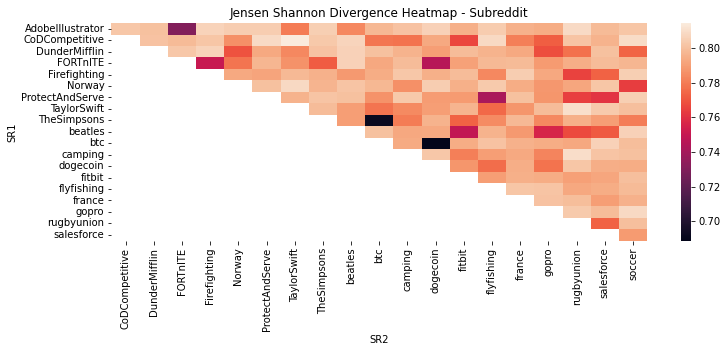

In [165]:
data = PAIRS.reset_index().pivot("SR1", "SR2", "jensenshannon")
ax = sns.heatmap(data)
ax.set_title('Jensen Shannon Divergence Heatmap - Subreddit')

In [166]:
data

SR2,CoDCompetitive,DunderMifflin,FORTnITE,Firefighting,Norway,ProtectAndServe,TaylorSwift,TheSimpsons,beatles,btc,camping,dogecoin,fitbit,flyfishing,france,gopro,rugbyunion,salesforce,soccer
SR1,,,,,,,,,,,,,,,,,,,
AdobeIllustrator,0.802433,0.800439,0.730406,0.806276,0.804482,0.804354,0.779723,0.804776,0.783286,0.797583,0.800820,0.805653,0.794854,0.804008,0.795726,0.794132,0.808656,0.798331,0.802074
CoDCompetitive,NaN,0.801034,0.798239,0.802130,0.785819,0.808773,0.814431,0.802847,0.806867,0.778501,0.777153,0.793329,0.765966,0.808350,0.780731,0.771818,0.801343,0.796119,0.809056
DunderMifflin,NaN,NaN,0.802596,0.806528,0.769035,0.792844,0.783352,0.800855,0.805601,0.800669,0.795941,0.789507,0.798854,0.796009,0.793026,0.768211,0.777065,0.800396,0.773498
FORTnITE,NaN,NaN,NaN,0.750485,0.777818,0.796819,0.786030,0.771500,0.805662,0.792582,0.799132,0.745283,0.790604,0.797951,0.798484,0.788426,0.794782,0.799149,0.797016
Firefighting,NaN,NaN,NaN,NaN,0.793158,0.791721,0.798123,0.795298,0.788075,0.793844,0.802345,0.795099,0.799056,0.783168,0.804155,0.792760,0.765013,0.773157,0.804992
Norway,NaN,NaN,NaN,NaN,NaN,0.800644,0.808101,0.796627,0.801547,0.797739,0.785822,0.804165,0.794816,0.803417,0.793921,0.787562,0.792066,0.802056,0.763560
ProtectAndServe,NaN,NaN,NaN,NaN,NaN,NaN,0.796120,0.801312,0.800260,0.786208,0.802780,0.788927,0.788818,0.741760,0.800457,0.787048,0.764069,0.761414,0.804663
TaylorSwift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798861,0.789771,0.777697,0.783669,0.789617,0.796343,0.775126,0.787243,0.799095,0.810491,0.803399,0.799825
TheSimpsons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.789649,0.691873,0.779784,0.796018,0.773118,0.784215,0.797941,0.783143,0.794907,0.789421,0.780506


### Dendrogram - Jensen Shannon Divergence

<Figure size 864x288 with 0 Axes>

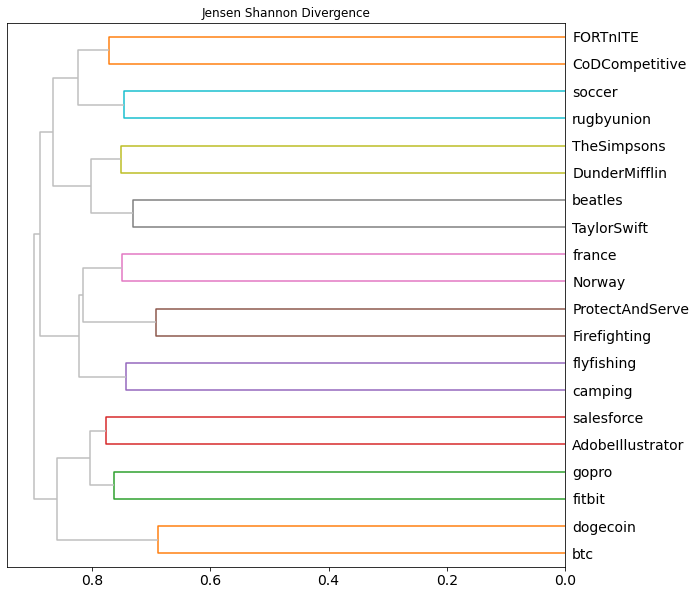

In [169]:
hca(PAIRS.jensenshannon, color_thresh=.8, title="Jensen Shannon Divergence")

### Dendrogram - Cosine Similarity

<Figure size 864x288 with 0 Axes>

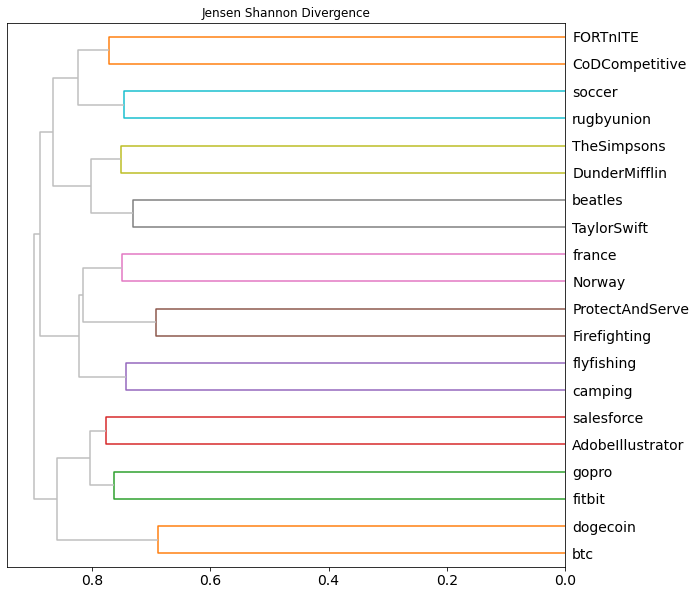

In [170]:
hca(PAIRS.jensenshannon, color_thresh=.8, title="Jensen Shannon Divergence")

# Save Work

In [171]:
%%time
# Prepare DCM - TFIDF by Subreddit
DCM = DCM.set_index(SUBREDDIT)

# Save Relevant Work
VOCAB.to_csv('VOCAB.csv')
TOKEN.to_csv('TOKEN.csv')
DOC.to_csv('DOC.csv')
LIB.to_csv('LIB.csv')
DTM_SR.to_csv('tfidf_DTM_SR.csv') #Document Term Matrix, TFIDF by Subreddit
DCM.to_csv('pca_DCM_SR.csv') #Principal Components by Subreddit

CPU times: user 53.9 s, sys: 663 ms, total: 54.5 s
Wall time: 54.5 s
